In [47]:
!pip install transformers datasets wordcloud nltk sumy rouge-score torch matplotlib gradio -q

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import sent_tokenize
import datasets
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from rouge_score import rouge_scorer
import gradio as gr
import warnings
warnings.filterwarnings('ignore')


In [48]:

print(" Downloading NLTK data...")
nltk.download('punkt')

print("All setup completed successfully!")
print("\n" + "="*60)

All setup completed successfully!



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
def load_dataset(sample_size=3):
    """Load CNN/DailyMail dataset or create sample data"""
    print("Loading dataset...")
    try:
        dataset = datasets.load_dataset('cnn_dailymail', '3.0.0', split='test')
        sample_data = dataset.select(range(sample_size))

        df = pd.DataFrame({
            'id': sample_data['id'],
            'article': sample_data['article'],
            'highlights': sample_data['highlights']
        })

        print(f"Loaded {len(df)} samples from CNN/DailyMail dataset")
        return df

    except Exception as e:
        print(f"Using sample data (dataset load failed: {e})")
        return create_sample_data()

def create_sample_data():
    """Create sample data for demonstration"""
    sample_texts = [
        "Climate change is one of the most pressing issues facing humanity today. Rising global temperatures, melting polar ice caps, and increasing frequency of extreme weather events are clear indicators of this phenomenon. Scientists worldwide agree that human activities, particularly the burning of fossil fuels, are the primary drivers of climate change. Immediate action is required to mitigate its effects and transition to renewable energy sources. Governments and industries must collaborate to reduce carbon emissions and invest in sustainable technologies.",
        "Artificial Intelligence has revolutionized various industries including healthcare, finance, and transportation. Machine learning algorithms can now diagnose diseases, predict market trends, and enable autonomous vehicles. However, ethical concerns regarding privacy, job displacement, and algorithmic bias need to be addressed. The future of AI depends on responsible development and deployment. Researchers are working on explainable AI and ethical frameworks to ensure technology benefits all of humanity.",
        "The COVID-19 pandemic has transformed global healthcare systems and work cultures. Remote work became the norm for many industries, accelerating digital transformation. Vaccine development achieved unprecedented speed through mRNA technology. The pandemic highlighted the importance of global cooperation in addressing health crises. Lessons learned will shape future pandemic preparedness and public health strategies worldwide."
    ]

    sample_summaries = [
        "Climate change driven by human activities requires immediate action through renewable energy transition and emission reduction strategies.",
        "AI revolution brings benefits but requires ethical frameworks for responsible development and deployment across industries.",
        "COVID-19 pandemic accelerated digital transformation and highlighted need for global cooperation in healthcare crises."
    ]

    df = pd.DataFrame({
        'id': range(1, 4),
        'article': sample_texts,
        'highlights': sample_summaries
    })

    print("Created sample data with 3 examples")
    return df

In [50]:
# Load data
df = load_dataset()
print("\n Sample Data Preview:")
print("=" * 50)
display(df.head())

print("\n" + "="*60)

Loading dataset...
Loaded 3 samples from CNN/DailyMail dataset

 Sample Data Preview:


,id,article,highlights
0,f001ec5c4704938247d27a44948eebb37ae98d01,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...
1,230c522854991d053fe98a718b1defa077a8efef,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b..."
2,4495ba8f3a340d97a9df1476f8a35502bcce1f69,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...


In [51]:
# Preprocessing
def preprocess_text(text, max_length=512):
    """Clean and truncate text for summarization"""
    # Remove extra whitespace
    text = ' '.join(text.split())

    # Truncate if too long (keep first max_length characters)
    if len(text) > max_length:
        text = text[:max_length] + "..."

    return text


In [52]:
# Preprocess articles
df['processed_article'] = df['article'].apply(lambda x: preprocess_text(x, 400))
print("Text preprocessing completed")
print(f"Sample processed text length: {len(df['processed_article'].iloc[0])} characters")

print("\n" + "="*60)

Text preprocessing completed
Sample processed text length: 403 characters



In [53]:
class SummarizationModels:
    def __init__(self):
        self.models = {
            'BART': 'facebook/bart-large-cnn',
            'T5': 't5-small',
            'Pegasus': 'google/pegasus-cnn_dailymail'
        }
        self.pipelines = {}

    def load_models(self):
        """Load all summarization models"""
        print("Loading summarization models...")

        for name, model_name in self.models.items():
            try:
                print(f"Loading {name}...")
                if name == 'T5':
                    self.pipelines[name] = pipeline(
                        "summarization",
                        model=model_name,
                        tokenizer=model_name,
                        framework="pt"
                    )
                else:
                    self.pipelines[name] = pipeline(
                        "summarization",
                        model=model_name,
                        tokenizer=model_name,
                        framework="pt"
                    )
                print(f"{name} model loaded successfully")
            except Exception as e:
                print(f"Error loading {name}: {e}")

    def summarize(self, text, model_name, max_length=100, min_length=30):
        """Generate summary using specified model"""
        try:
            if model_name == 'T5':
                text = "summarize: " + text

            summary = self.pipelines[model_name](
                text,
                max_length=max_length,
                min_length=min_length,
                do_sample=False,
                truncation=True
            )
            return summary[0]['summary_text']
        except Exception as e:
            return f"Error: {str(e)}"


In [54]:
# Initialize and load models
print("Initializing summarization models...")
summarizer = SummarizationModels()
summarizer.load_models()



Initializing summarization models...
Loading summarization models...
Loading BART...


Device set to use cpu


BART model loaded successfully
Loading T5...


Device set to use cpu


T5 model loaded successfully
Loading Pegasus...


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Pegasus model loaded successfully


In [55]:
# Generate summaries for all samples
print("\n Generating summaries...")
results = []
for idx, row in df.iterrows():
    article = row['processed_article']
    row_result = {'id': row['id'], 'original': article[:200] + "..."}

    for model_name in summarizer.pipelines.keys():
        summary = summarizer.summarize(article, model_name, max_length=80, min_length=20)
        row_result[model_name] = summary
        print(f"   {model_name}: {summary[:60]}...")

    results.append(row_result)
    print(f"Completed sample {idx + 1}/{len(df)}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Your max_length is set to 80, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)



 Generating summaries...
   BART: The Palestinian Authority officially became the 123rd member...


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 80, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


   T5: the Palestinian Authority officially became the 123rd member...
   Pegasus: The Palestinian Authority officially became the 123rd member...
Completed sample 1/3
   BART: The dog was hit by a car, apparently whacked on the head wit...


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   T5: a stray pooch in Washington state has used up at least three...
   Pegasus: A stray dog in Washington State was hit by a car and buried ...
Completed sample 2/3


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


   BART: Mohammad Javad Zarif is the Iranian foreign minister. He has...
   T5: mohammad Javad Zarif has been u.s. secretary of state's oppo...
   Pegasus: Iran's foreign minister has been key in securing a breakthro...
Completed sample 3/3


In [56]:
# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n Summarization Results:")
print("=" * 80)
display(results_df)

print("\n" + "="*60)


 Summarization Results:


,id,original,BART,T5,Pegasus
0,f001ec5c4704938247d27a44948eebb37ae98d01,(CNN)The Palestinian Authority officially beca...,The Palestinian Authority officially became th...,the Palestinian Authority officially became th...,The Palestinian Authority officially became th...
1,230c522854991d053fe98a718b1defa077a8efef,(CNN)Never mind cats having nine lives. A stra...,"The dog was hit by a car, apparently whacked o...",a stray pooch in Washington state has used up ...,A stray dog in Washington State was hit by a c...
2,4495ba8f3a340d97a9df1476f8a35502bcce1f69,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif is the Iranian foreign mi...,mohammad Javad Zarif has been u.s. secretary o...,Iran's foreign minister has been key in securi...


In [57]:
# 5 Extractive Summarization (Bonus)
def textrank_summarize(text, sentences_count=2):
    """Extractive summarization using TextRank"""
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = TextRankSummarizer()
        summary = summarizer(parser.document, sentences_count)
        return " ".join([str(sentence) for sentence in summary])
    except Exception as e:
        return f"Error: {str(e)}"

In [58]:
print( "Adding TextRank extractive summaries...")
results_df['TextRank'] = df['processed_article'].apply(
    lambda x: textrank_summarize(x, sentences_count=2)
)


Adding TextRank extractive summaries...


In [59]:
# Evaluation
def calculate_rouge_scores(reference, candidate):
    """Calculate ROUGE scores between reference and candidate"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

In [60]:
# Evaluate against reference highlights
print("Evaluating model performance with ROUGE scores...")
evaluation_results = []

for idx, row in df.iterrows():
    reference = row['highlights']

    for model in ['BART', 'T5', 'Pegasus', 'TextRank']:
        candidate = results_df.iloc[idx][model]
        scores = calculate_rouge_scores(reference, candidate)

        evaluation_results.append({
            'sample_id': row['id'],
            'model': model,
            'rouge1': round(scores['rouge1'].fmeasure, 3),
            'rouge2': round(scores['rouge2'].fmeasure, 3),
            'rougeL': round(scores['rougeL'].fmeasure, 3),
            'summary_length': len(candidate.split())
        })

Evaluating model performance with ROUGE scores...


In [61]:
# Create evaluation DataFrame
eval_df = pd.DataFrame(evaluation_results)
print("\n Detailed ROUGE Scores:")
display(eval_df)

# Average scores by model
avg_scores = eval_df.groupby('model')[['rouge1', 'rouge2', 'rougeL']].mean()
print("\n Average ROUGE Scores by Model:")
display(avg_scores.round(3))



 Detailed ROUGE Scores:


,sample_id,model,rouge1,rouge2,rougeL,summary_length
0,f001ec5c4704938247d27a44948eebb37ae98d01,BART,0.197,0.000,0.164,27
1,f001ec5c4704938247d27a44948eebb37ae98d01,T5,0.190,0.000,0.159,31
2,f001ec5c4704938247d27a44948eebb37ae98d01,Pegasus,0.433,0.241,0.300,26
3,f001ec5c4704938247d27a44948eebb37ae98d01,TextRank,0.074,0.000,0.059,72
4,230c522854991d053fe98a718b1defa077a8efef,BART,0.494,0.240,0.468,33
5,230c522854991d053fe98a718b1defa077a8efef,T5,0.333,0.132,0.205,35
6,230c522854991d053fe98a718b1defa077a8efef,Pegasus,0.493,0.254,0.384,28
7,230c522854991d053fe98a718b1defa077a8efef,TextRank,0.069,0.000,0.028,72
8,4495ba8f3a340d97a9df1476f8a35502bcce1f69,BART,0.483,0.250,0.310,22
9,4495ba8f3a340d97a9df1476f8a35502bcce1f69,T5,0.333,0.086,0.250,37



 Average ROUGE Scores by Model:


,rouge1,rouge2,rougeL
model,,,
BART,0.391,0.163,0.314
Pegasus,0.418,0.210,0.294
T5,0.285,0.073,0.205
TextRank,0.072,0.000,0.044


<Figure size 1200x600 with 0 Axes>

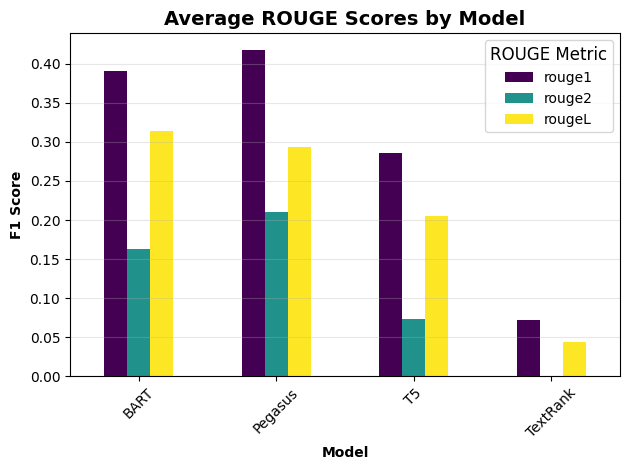

In [62]:
# Plot average scores
plt.figure(figsize=(12, 6))
avg_scores.plot(kind='bar', colormap='viridis')
plt.title('Average ROUGE Scores by Model', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.xlabel('Model', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='ROUGE Metric', title_fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("\n" + "="*60)



In [63]:
 # Visualization
def create_wordcloud(text, title, figsize=(10, 5)):
    """Generate word cloud from text"""
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Generating Word Clouds for Sample 1
Original Text Word Cloud:


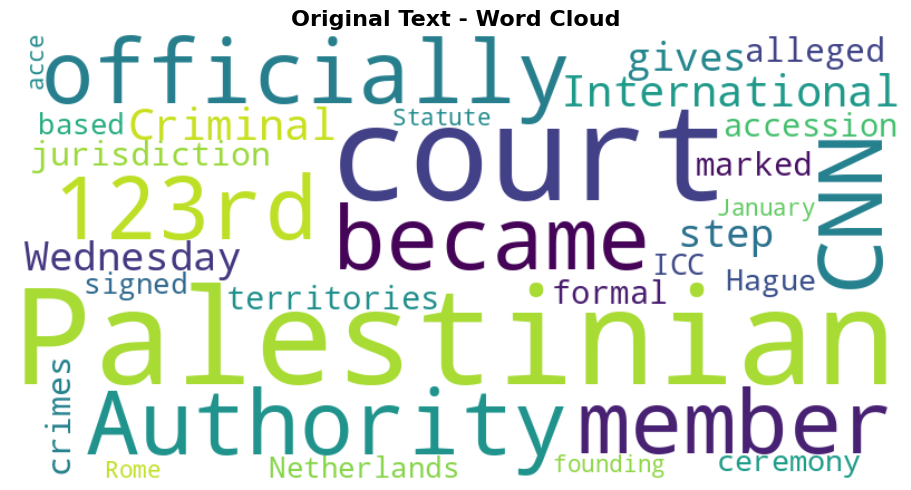

BART Summary Word Cloud:


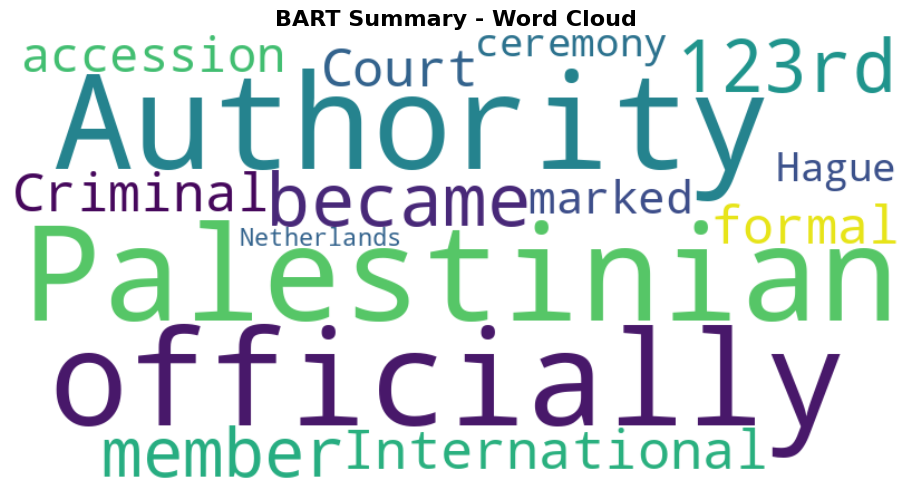

In [64]:
 #Compare word clouds for first sample
sample_idx = 0
print("Generating Word Clouds for Sample 1")
original_text = df.iloc[sample_idx]['processed_article']
summary_text = results_df.iloc[sample_idx]['BART']

print("Original Text Word Cloud:")
create_wordcloud(original_text, "Original Text - Word Cloud")

print("BART Summary Word Cloud:")
create_wordcloud(summary_text, "BART Summary - Word Cloud")

In [65]:
def interactive_summarizer(text, model_choice, max_length=100):
    """Interactive summarization function for Gradio"""
    if not text.strip():
        return "Please enter some text to summarize."

    try:
        if model_choice == "TextRank":
            summary = textrank_summarize(text, sentences_count=2)
        else:
            summary = summarizer.summarize(text, model_choice, max_length=max_length)
        return summary
    except Exception as e:
        return f"Error: {str(e)}"


In [66]:
iface = gr.Interface(
    fn=interactive_summarizer,
    inputs=[
        gr.Textbox(
            label="Input Text",
            lines=6,
            placeholder="Enter or paste text here to summarize...\nExample: 'Artificial Intelligence is transforming industries...'",
            value=df.iloc[1]['processed_article']
        ),
        gr.Dropdown(
            choices=["BART", "T5", "Pegasus", "TextRank"],
            label="Model",
            value="BART",
            info="Choose summarization model"
        ),
        gr.Slider(
            minimum=30,
            maximum=200,
            value=80,
            label="Max Summary Length",
            info="Maximum number of words in summary"
        )
    ],
    outputs=gr.Textbox(
        label="Generated Summary",
        lines=3,
        show_copy_button=True
    ),
    title=" Text Summarization Demo",
    description="Enter text and choose a model to generate instant summaries!",
    examples=[
        [df.iloc[0]['processed_article'], "BART", 80],
        [df.iloc[1]['processed_article'], "Pegasus", 70],
        [df.iloc[2]['processed_article'], "TextRank", 60]
    ],
    theme="soft",
    allow_flagging="never"
)

In [67]:
iface.launch(share=True, debug=False, show_error=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://46bace7d634eb3853f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
